In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Exogenous introduction of new knowledge and effect on spillovers

1. Find patents with "software" in abstract
2. Merge patent with unique assignees
3. Get new firms that applied for patents for the first time in 1995-1996 (In re Alappat, July 1994 - see Hall & MacGarvie) in primary classes from 1
4. Get existing patents in primary classes from 1 applied for at same time
5. Get sample of other patents applied for 1985-2005: PRIOR patents; 1985-1995: POST patents 1995-2005. NOTE: this includes Dotcom bubble burst of 2000.
6. Get similarity calculations for all pairs for within NAICS sample

### Spillover measures

1. Measure similarity for both samples (a) within NAICS - all; (b) within primary class over time
    - Expectation: Lower for new firm patents and then higher after 2001. Higher for existing firm patents and then lower after 2001.
2. Measure localization for sample (a) within NAICS - all; (b) within primary class over time
    - Expectation: Decline in localization 1999-2000, increase after, then fall
    
### Location measures
For each primary class plus NAICS, get distribution over locations for each year
1. HHI index of location concentration time series
2. Cosine similarity of location distributions over time

In [2]:
# Merge patent with application year
# pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
# print(len(pdf))
# p2 = pd.read_pickle("RawData/HBSPatData/invpat_us_7509_loc_unique.pkl")[["patent", "appyear"]]
# pdf = pdf.merge(p2, how = "left", on = "patent")
# print(len(pdf))
# fastparquet.write("RawData/Cleaned/patent_loc_unique_us_0628.parq", pdf, compression="GZIP")

### 1. Software patent patterns

In [3]:
# 1. Software in abstract
pabs = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas()
print(len(pabs))
pabs = pabs.loc[pabs["Abstract"].apply(lambda x: "software" in x.lower())]
print(len(pabs))

2575725
28241


In [4]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
# Load data
pdf = pdf.drop_duplicates("patent")
# Remove actual duplicates
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl")
pdf = pdf.loc[~(pdf["patent"].isin(dup_pats))]
asg = fastparquet.ParquetFile("RawData/Cleaned/patent_assignees_unique_0628.parq").to_pandas()
pc = pd.read_table("RawData/PatentView/uspc_current.tsv")

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
sw_pats = pdf.loc[pdf["patent"].isin(pabs["patent"])]
#NAICS
sw_naics = sw_pats["naics_name"].value_counts()
print(len(sw_pats))
sw_naics = sw_naics[sw_naics >= 100]
sw_pats = sw_pats.loc[sw_pats["naics_name"].isin(sw_naics.index)]
print(len(sw_pats))
# Primclass
sw_pc = sw_pats["primclass"].value_counts()
sw_pc = sw_pc[sw_pc >= 50]
print(len(sw_pats))
sw_pats = sw_pats.loc[sw_pats["primclass"].isin(sw_pc.index)]
print(len(sw_pats))

22331
21062
21062
19916


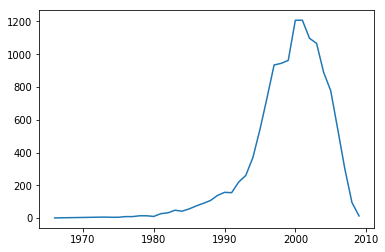

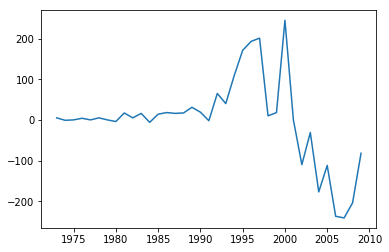

In [6]:
%matplotlib inline
sw_appyear = sw_pats["appyear"].value_counts().sort_index()
sw_appyear.plot.line()
plt.show()
sw_appyear.diff().plot.line()
plt.show()

In [7]:
sw_appyear

1966.0       1
1973.0       6
1974.0       5
1975.0       5
1976.0       9
1977.0       9
1978.0      14
1979.0      14
1980.0      10
1981.0      27
1982.0      32
1983.0      48
1984.0      42
1985.0      56
1986.0      74
1987.0      90
1988.0     107
1989.0     138
1990.0     157
1991.0     155
1992.0     220
1993.0     260
1994.0     369
1995.0     540
1996.0     733
1997.0     934
1998.0     944
1999.0     962
2000.0    1207
2001.0    1207
2002.0    1097
2003.0    1066
2004.0     889
2005.0     777
2006.0     540
2007.0     299
2008.0      95
2009.0      13
Name: appyear, dtype: int64

In [8]:
# # 4. Merge with assignees
sw_pats = sw_pats.merge(asg, how = "left", on = "patent")
del(asg)

# 5. Drop duplicate assignees
s_asg = sw_pats[["assignee_id", "appyear"]].drop_duplicates("assignee_id", keep="first")

# 6. Number of first assignees by year
sts = s_asg["appyear"].value_counts().sort_index()

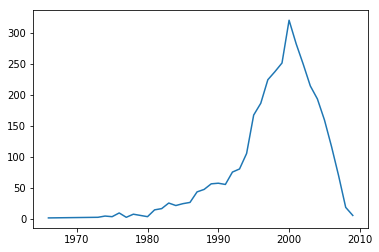

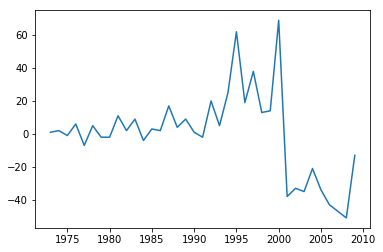

In [9]:
%matplotlib inline
sts.plot.line()
plt.show()
sts.diff().plot.line()
plt.show()

## 1. Location measures
### 1.1. Location distributions of new patents at each year

In [10]:
yr_min = 1990
yr_max = 2005
p3 = sw_pats.loc[(sw_pats["appyear"] >= yr_min) & (sw_pats["appyear"] <= yr_max)]
ploc = p3[["inv_msa", "appyear", "patent"]].groupby(["inv_msa", "appyear"]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.loc[ploc["patent"] >= 10]
ploc = ploc.pivot(index="appyear", columns="inv_msa", values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

30


In [11]:
sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(yr_min,yr_max+1)), index=list(range(yr_min,yr_max+1))).unstack().reset_index()
sim.columns=["appyear1", "appyear2", "sim_location"]
sim["lag"] = sim["appyear2"]-sim["appyear1"]

In [12]:
# Timeline of lag1
sim1 = sim.loc[sim["lag"] == 1, ["appyear1", "sim_location"]].set_index("appyear1")

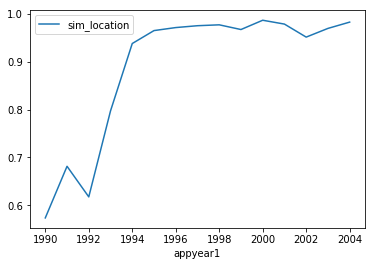

In [13]:
%matplotlib inline
# Plot
sim1.plot.line()

In [14]:
# Similarity to distribution at 1995 over time
sim2 = sim.loc[sim["appyear1"] == 1995, ["lag", "sim_location"]].set_index("lag")

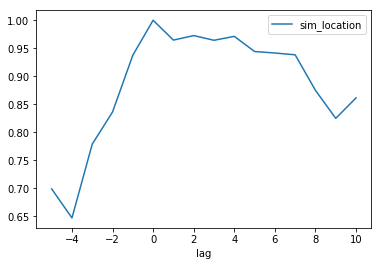

In [15]:
%matplotlib inline
# Plot
sim2.plot.line()

### 1.2 HHI for each year

In [16]:
hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))

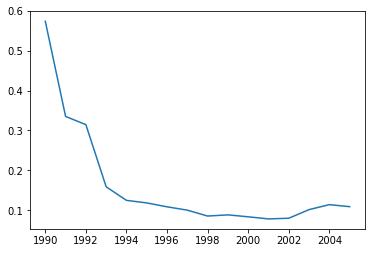

In [17]:
%matplotlib inline
# Plot
hhi.plot.line()

## 2. Similarity comparison of new patents 1995-6

### 2.1 First sample
Sampling procedure:
1. Get all new assignee patents 1995-96; get same number of existing assignee patents
2. For each patent, for each year: assign one patent from (a) same NAICS; (b) same primclass

In [18]:
# 1. Get new assignees 1995-6
beg=1995
end=2000
n_asg = s_asg.loc[s_asg["appyear"].isin(range(beg,end+1)), "assignee_id"].tolist()
p4 = p3.loc[p3["assignee_id"].isin(n_asg) & p3["appyear"].isin(range(beg,end+1))].copy()
p4["group"] = "new_software"
print(len(p4))

2486


In [19]:
p5 = p3.loc[~p3["assignee_id"].isin(n_asg) & p3["appyear"].isin(range(beg,end+1))].copy()
p5["group"] = "old_software"
print(len(p5))

2834


In [20]:
# Target patents
tp = p4[["patent", "primclass", "naics_name", "appyear", "group"]].append\
(p5[["patent", "primclass", "naics_name", "appyear", "group"]].sample(n=1000))

# Times 10
tp2 = pd.DataFrame()
for i in range(10):
    tp2 = tp2.append(tp, ignore_index=True)
tp2["tp"] = tp2["patent"]
tp2 = tp2.drop("patent",1)
len(tp2)

34860

In [21]:
# NAICS patents; p3 is primclass patents
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
pn = pdf.loc[pdf["appyear"].isin(range(yr_min, yr_max+1)) & (pdf["naics_name"].isin(sw_naics.index))].copy()
ppc = pdf.loc[pdf["appyear"].isin(range(yr_min, yr_max+1)) & (pdf["primclass"].isin(sw_pc.index))].copy()
del(pdf)

In [22]:
# %%time
for k in ["naics_name", "primclass"]:
    if k == "naics_name":
        prel = pn
    else:
        prel = ppc
    png = prel[["patent", "appyear", k]].groupby(["appyear", k])
    tpg = tp2.groupby(k)
    psamp = pd.DataFrame()
    for m,g in png:
        try:
            o = tpg.get_group(m[1])
            g = g.loc[~g["patent"].isin(o["tp"])].copy()
            o["op"] = g.sample(n = len(o), replace=True)["patent"].tolist()
            psamp = psamp.append(o, ignore_index=True)
        except Exception:
            pass
    psamp.to_pickle("DataStore/2018-07-P2/Software/software_{0}_0720.pkl".format(k))

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
psamp.head()

,primclass,naics_name,appyear,group,tp,op
0,1.0,Other Miscellaneous,1995.0,new_software,5550971,5761493
1,1.0,Other Miscellaneous,1995.0,new_software,5551028,5761493
2,1.0,Other Miscellaneous,1995.0,new_software,5634056,5369761
3,1.0,Other Miscellaneous,1995.0,new_software,5659732,5278954
4,1.0,Other Miscellaneous,1996.0,new_software,5675780,5251314


### 2.2 Second sample
- Compare similarity of patents in software primclass (sw_primclass) 1993-1994 to other patents in same NAICS and primary class, to similarity of patents *not* in software primclass but in software naics

In [24]:
ptreat = ppc.loc[ppc["appyear"].isin([1993,1994])].sample(frac=0.5)[["patent", "naics_name", "primclass", "appyear"]]
ptreat["group"] = "software"
pcont = pn.loc[pn["appyear"].isin([1993,1994]) & ~(pn["primclass"].isin(sw_pc.index))].sample(frac=0.01)[["patent", "naics_name", "primclass", "appyear"]]
pcont["group"] = "non-software"

In [25]:
# Times 10
tp2 = pd.DataFrame()
for i in range(10):
    tp2 = tp2.append(ptreat, ignore_index=True)
    tp2 = tp2.append(pcont)
tp2["tp"] = tp2["patent"]
tp2 = tp2.drop("patent",1)
len(tp2)

114810

In [29]:
# %%time
for k in ["naics_name", "primclass"]:
    if k == "naics_name":
        prel = pn
    else:
        prel = ppc
    png = prel[["patent", "appyear", k]].groupby(["appyear", k])
    tpg = tp2.groupby(k)
    psamp = pd.DataFrame()
    for m,g in png:
        try:
            o = tpg.get_group(m[1])
            g = g.loc[~g["patent"].isin(o["tp"])].copy()
            o["op"] = g.sample(n = len(o), replace=True)["patent"].tolist()
            psamp = psamp.append(o, ignore_index=True)
        except Exception:
            pass
    psamp.to_pickle("DataStore/2018-07-P2/Software/software_pc_{0}_0720.pkl".format(k))

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
psamp["group"]

0          software
1          software
2          software
3          software
4          software
5          software
6          software
7          software
8          software
9          software
10         software
11         software
12         software
13         software
14         software
15         software
16         software
17         software
18         software
19         software
20         software
21         software
22         software
23         software
24         software
25         software
26         software
27         software
28         software
29         software
             ...   
1767490    software
1767491    software
1767492    software
1767493    software
1767494    software
1767495    software
1767496    software
1767497    software
1767498    software
1767499    software
1767500    software
1767501    software
1767502    software
1767503    software
1767504    software
1767505    software
1767506    software
1767507    software
1767508    software
